# Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib
import shap

import warnings
warnings.filterwarnings('ignore')

SCALE_POS_WEIGHT = 187140 / 12382  # SCALE_POS_WEIGHT is approximately 15:1 from the ration of count in dataset

In [ ]:
column_names = []
with open('data/census-bureau.columns', 'r') as f:
    for line in f:
        column_names.append(line.strip().replace(" ","_"))

df = pd.read_csv("data/census-bureau.data", delimiter=",")
df.columns = column_names

# Preprocessing

In [3]:
df = df.copy()
rename_dict = {
    "fill_inc_questionnaire_for_veteran's_admin": "fill_inc_questionnaire_for_veterans_admin",
    'migration_code-change_in_msa': 'migration_code_change_in_msa',
    'migration_code-change_in_reg': 'migration_code_change_in_reg',
    'migration_code-move_within_reg': 'migration_code_move_within_reg'
}
df['hispanic_origin'] = df['hispanic_origin'].fillna('Do not know')
df.rename(columns=rename_dict, inplace=True)
df['label'] = df['label'].map({'- 50000.':0, '50000+.':1})  # Map values to 1 & 0
df['net_gains'] = (df['capital_gains'] + df['dividends_from_stocks'] - df['capital_losses'])

In [4]:
# based on the EDA in another file, dropping a few columns which do not add up significantly in model predictions.
cols_to_drop = ['label', 'weight', 'capital_gains', 'dividends_from_stocks', 'capital_losses', 'fill_inc_questionnaire_for_veterans_admin', 'veterans_benefits', 'year',
                'enroll_in_edu_inst_last_wk', 'citizenship', 'country_of_birth_self', 'region_of_previous_residence', 'state_of_previous_residence']

X = df.drop(columns=cols_to_drop)
y = df['label']
census_weights = df['weight'].values                        # Get the sample weights for loss function while modeling

# Numeric and Categoritcal Transformations

In [5]:
# Get the Numeric and Categorical Features Separately
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

cat_idx = [X.columns.get_loc(col) for col in categorical_features] # For SMOTENC

# Transform the Features to Impute Missing values, with methods like (median, most_frequent, mean, etc) but this has already been taken care while preprocessing
# Scale the numeric values, Encode the categorical values
numeric_transformer = Pipeline(
    steps=[
        #('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# Convert all the categorical features using OneHotEncoding for a few models and OrdinalEncoding for another for standardized conversion
ohe_categorical_transformer = Pipeline(
    steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

# OrdinalEncoding
oe_categorical_transformer = Pipeline(
    steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ]
)

# Preprocess with the above Transformations for Linear models
lr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', ohe_categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# For Tree based or Ensemble Models, scaling numeric features is not required as algorithm handles outliers or min max value ranges
# Separate Pipeline for RandomForest and HGB
rf_hgb_based_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe_categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Separate Pipeline for XGB and LightGBM with OrdinalEncoding
xgb_lgb_based_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', oe_categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Train-Test-Val Split

In [6]:
# Divide the dataset into train test and validation
# Keep a part of data completete UNSEEN as test set for inference
# Out of the remaining data, divide the data furthermore into training and validation to get offline metrics
# Add SMOTE Sampling only for Training data and not for the test data to avoid leakage and stratify label

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, stratify=y_train_full, random_state=7)

print("Original training shape: ", X_train.shape)
print("Original class distribution:\n", y_train.value_counts())

# SMOTE and resample - SMOTENC for mixed data types, it considers both categorical and numeric features
# Using SMOTE here, so weights column in the dataset will become unnecessary while predicting, If SMOTE was not used, then weights column could be passed while fitting the model,
# ignoring weights column while training
sm = SMOTENC(categorical_features=cat_idx, sampling_strategy='auto', random_state=7)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print("Resampled shape:", X_train_resampled.shape)
print("Resampled class distribution:\n", y_train_resampled.value_counts())

Original training shape:  (139659, 30)
Original class distribution:
 label
0    130992
1      8667
Name: count, dtype: int64

After SMOTE:
Resampled shape: (261984, 30)
Resampled class distribution:
 label
0    130992
1    130992
Name: count, dtype: int64


# Training with Hyperparameter Search

In [7]:
# Define Model Pipelines

# Logistic Regression
lrc = ImbPipeline(
    steps=[
        ('preprocessor', lr_preprocessor),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=1))
    ]
)

# Random Forest Classifier
rfc = ImbPipeline(
    steps=[
        ('preprocessor', rf_hgb_based_preprocessor),
        ('clf', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=7))
    ]
)

# Histogram Gradient Boosting
hgb = ImbPipeline(
    steps=[
        ('preprocessor', rf_hgb_based_preprocessor),
        ('clf', HistGradientBoostingClassifier(random_state=7))
    ]
)

# XGBoost
xgb = ImbPipeline(
    steps=[
        ('preprocessor', xgb_lgb_based_preprocessor),
        ('clf', XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='auc',
            random_state=7,
            n_jobs=-1,
            scale_pos_weight=SCALE_POS_WEIGHT
        ))
    ]
)

# LightGBM
lgbm = ImbPipeline(
    steps=[
        ('preprocessor', xgb_lgb_based_preprocessor),
        ('clf', lgb.LGBMClassifier(
            objective='binary',
            metric='auc',
            random_state=7,
            n_jobs=-1,
            scale_pos_weight=SCALE_POS_WEIGHT
        ))
    ]
)

In [8]:
# Define Hyperparameter Search Space
logistic_regression_params = {
    'clf__C': np.logspace(-2,2,20),
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'liblinear']
}

random_forest_params = {
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [None, 5, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__bootstrap': [True, False]
}

hist_gb_params = {
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__max_depth': [None, 3, 5, 7, 10],
    'clf__max_leaf_nodes': [15, 31, 63, 127],
    'clf__min_samples_leaf': [20, 10, 5],
    'clf__l2_regularization': [0.0, 0.1, 1.0],
    'clf__max_bins': [255, 128, 64],
}

xgb_params = {
    'clf__n_estimators': [100, 300, 500],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_depth': [3, 5, 7, 9],
    'clf__gamma': [0, 0.1, 0.5]
}

lgbm_params = {
    'clf__n_estimators': [100, 300, 500],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__num_leaves': [20, 31, 40],
    'clf__min_child_samples': [10, 20, 30]
}

In [9]:
# Stratified Cross Validation Step
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

In [10]:
# Randomized search CV per model
def run_search(pipeline, param_config, X_train, y_train, cv, n_iter=25):
  search = RandomizedSearchCV(
      pipeline,
      param_distributions=param_config,
      n_iter=n_iter,
      scoring='roc_auc',
      cv=cv,
      n_jobs=1,
      verbose=3,
      random_state=7
  )

  search.fit(X_train, y_train)

  return search

In [11]:
# Train the models
print("\nXGBoost")
xgboost_search = run_search(pipeline=xgb,param_config=xgb_params, X_train=X_train_resampled, y_train=y_train_resampled, cv=cv)
print("\nLightGBM")
lightgbm_search = run_search(pipeline=lgbm, param_config=lgbm_params, X_train=X_train_resampled, y_train=y_train_resampled, cv=cv)
print("\nLogistic Regression")
logistic_regression_search = run_search(pipeline=lrc, param_config=logistic_regression_params, X_train=X_train_resampled, y_train=y_train_resampled, cv=cv)
print("\nHistogram Gradient Boost")
hist_grad_boost_search = run_search(pipeline=hgb, param_config=hist_gb_params, X_train=X_train_resampled, y_train=y_train_resampled, cv=cv)
print("\nRandom Forest classifier")
random_forests_search = run_search(pipeline=rfc, param_config=random_forest_params, X_train=X_train_resampled, y_train=y_train_resampled,  cv=cv)


XGBoost
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END clf__gamma=0.1, clf__learning_rate=0.05, clf__max_depth=5, clf__n_estimators=100;, score=nan total time=   1.9s
[CV 2/5] END clf__gamma=0.1, clf__learning_rate=0.05, clf__max_depth=5, clf__n_estimators=100;, score=nan total time=   1.8s
[CV 3/5] END clf__gamma=0.1, clf__learning_rate=0.05, clf__max_depth=5, clf__n_estimators=100;, score=0.963 total time=   1.5s
[CV 4/5] END clf__gamma=0.1, clf__learning_rate=0.05, clf__max_depth=5, clf__n_estimators=100;, score=0.962 total time=   2.3s
[CV 5/5] END clf__gamma=0.1, clf__learning_rate=0.05, clf__max_depth=5, clf__n_estimators=100;, score=0.963 total time=   1.5s
[CV 1/5] END clf__gamma=0.5, clf__learning_rate=0.05, clf__max_depth=3, clf__n_estimators=100;, score=nan total time=   1.3s
[CV 2/5] END clf__gamma=0.5, clf__learning_rate=0.05, clf__max_depth=3, clf__n_estimators=100;, score=nan total time=   1.3s
[CV 3/5] END clf__gamma=0.5, clf__learning_rate=

# Evaluation

In [12]:
# Compare the best CV ROC-AUC Scores
results = [
    ('LogisticRegression', logistic_regression_search.best_score_, logistic_regression_search.best_estimator_),
    ('RandomForests', random_forests_search.best_score_, random_forests_search.best_estimator_),
    ('HistogramGradientBoost', hist_grad_boost_search.best_score_, hist_grad_boost_search.best_estimator_),
    ('XGBoost', xgboost_search.best_score_, xgboost_search.best_estimator_),
    ('LightGBM', lightgbm_search.best_score_, lightgbm_search.best_estimator_)
]

# Get top results
top_results = sorted(results, key=lambda x:x[1], reverse=True)

# Get the Best Model
best_model_name, best_cv_auc, best_model = top_results[0]

print(f"Best Model: {best_model_name} with CV ROC-AUC={best_cv_auc: .4f}")
print("Best params: ", best_model.get_params())

Best Model: HistogramGradientBoost with CV ROC-AUC= 0.9774
Best params:  {'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['class_of_worker', 'education',
                                  'marital_stat', 'major_industry_code',
                                  'major_occupation_code', 'race',
                                  'hispanic_origin', 'sex',
                                  'member_of_a_labor_union',
                                  'reason_for_unemployment',
                                  'full_or_part_time_employment_stat',
                                  'tax_filer_stat',
                                  'detailed_household_and_family_stat',
                     

In [13]:
# Fit the Best Model
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['class_of_worker',
                                                   'education', 'marital_stat',
                                                   'major_industry_code',
                                                   'major_occupation_code',
                                                   'race', 'hispanic_origin',
                                                   'sex',
                                                   'member_of_a_labor_union',
                                                   'reason_for_unemployment',
                                                   'full_or_part_t...
                                                   'migration_code_change_in_msa',
                                                   'migration_code_change_in_reg',
                                                   'migration_code_move_within_reg',
                                                   'live_in_this_house_1_year_ago',
                                                   'migration_prev_res_in_sunbelt',
                                                   'family_members_under_18',
                                                   'country_of_birth_father',
                                                   'country_of_birth_mother'])])),
                ('clf',
                 HistGradientBoostingClassifier(l2_regularization=0.1,
                                                learning_rate=0.2, max_bins=128,
                                                max_leaf_nodes=127,
                                                random_state=7))])

In [14]:
# Predict the probabilities on validation dataset
y_val_prob = best_model.predict_proba(X_val)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_val)

In [15]:
# Threshold to maximize the F1 metrics on validatino dataset
thresholds = np.linspace(0.1, 0.9, 81)
f1s = []
for t in thresholds:
  y_val_pred = (y_val_prob >= t).astype(int)
  f1s.append(f1_score(y_val, y_val_pred))
best_t = thresholds[int(np.argmax(f1s))]
print(f"Chosen Threshold={best_t} (F1 on validation={max(f1s)})")

Chosen Threshold=0.24000000000000002 (F1 on validation=0.516775396085741)


In [16]:
# Final Evaluation on Test Dataset
y_test_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test)
y_test_pred = (y_test_proba >= best_t).astype(int)

test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1': f1_score(y_test, y_test_pred),
    'ROC_AUC': roc_auc_score(y_test, y_test_pred),
    'PR_AUC': average_precision_score(y_test, y_test_pred)
}

print("Test Metrics ", {key: round(value, 4) for key, value in test_metrics.items()})

Test Metrics  {'Accuracy': 0.9302, 'Precision': 0.4508, 'Recall': 0.5724, 'F1': 0.5044, 'ROC_AUC': np.float64(0.7631), 'PR_AUC': np.float64(0.2846)}


In [17]:
y_test = y_test.copy()

# Get probabilities
proba = (
    best_model.predict_proba(X_test)[:, 1]
    if hasattr(best_model, "predict_proba")
    else best_model.decision_function(X_test)
)

results = pd.DataFrame(
    {
        "label": y_test.values,
        "proba": proba,
    },
    index=y_test.index
)

# Apply threshold
results["pred"] = (results["proba"] >= best_t).astype(int)

results

,label,proba,pred
8459,0,0.005505,0
91636,0,0.147375,0
119367,0,0.044389,0
104524,0,0.101283,0
190996,0,0.033984,0
...,...,...,...
28759,0,0.000115,0
70837,0,0.000583,0
46455,0,0.000283,0
74624,0,0.000115,0


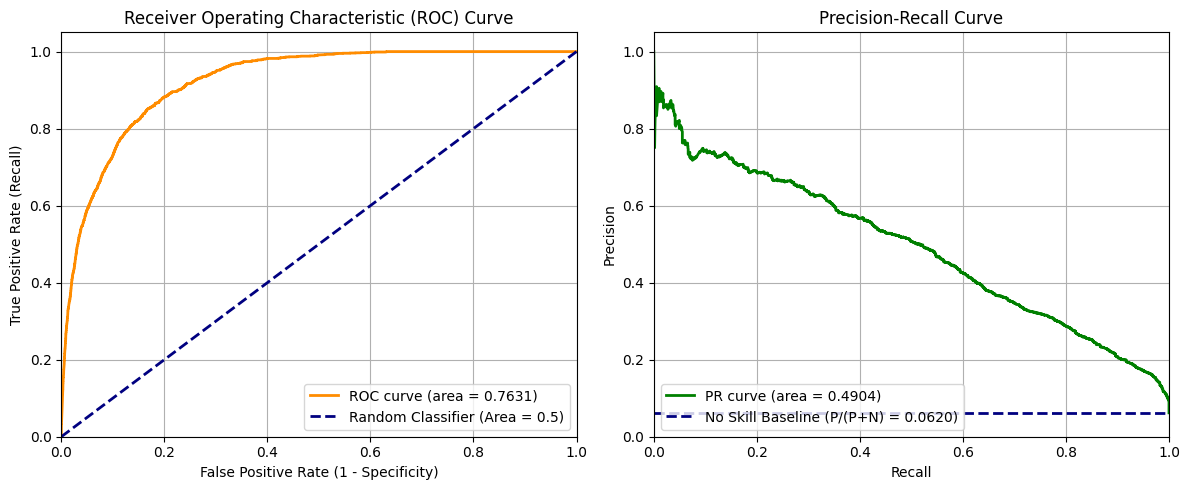

In [18]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_metrics["ROC_AUC"]:0.4f})') #  ROC Curve

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (Area = 0.5)') # diagonal baseline

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2) # Precision-Recall Curve Plot

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_proba) # Calculate Precision-Recall pairs

pr_auc = auc(recall, precision) # Area under the curve

plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (area = {pr_auc:0.4f})') # PR Curve

no_skill = len(y_test[y_test==1]) / len(y_test) # Bo skill Baseline is the ratio of positive class (P / (P+N))
plt.plot([0, 1], [no_skill, no_skill], color='navy', lw=2, linestyle='--', label=f'No Skill Baseline (P/(P+N) = {no_skill:0.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()

# Deployment (Offline Saving and Loading)

In [ ]:
## Save the model and use for deployment inference
joblib.dump({
    'model': best_model,
    'threshold': float(best_t),
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
}, 'models/classifier.joblib')

['/content/drive/MyDrive/JPMC Assessment/models/classifier.joblib']

In [ ]:
## Use the deployed model for inference
artifact = joblib.load('models/classifier.joblib')
model = artifact['model']
threshold = artifact['threshold']

# Infer on Sample test data
prob = model.predict_proba(X_test[:10])[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test[:10])
pred = (prob >= threshold).astype(int)